## Demo for GW Signal Injection 
This demonstration shows examples for the injection of GW signals.    
The waveforms of GWs may come from analytical expressions, external codes, time series data, and SGWB spectra.    
The simulations in this demo do not include noises, and a noisy data can be  generated by simply turning on the switch of noises in the simulator.   
``Triangle``  provides multiple implementations for the calculation of GW responses.   
In this demo, we show the one integrated to the ``Interferometers`` class.   
Most GW signals can be injected through the following steps:   

<img src="../Figures/GWInjection.png" alt="Drawing" style="width: 1000px;" align="center">

<!-- It should be noticed that ``Triangle`` is designed as a prototype simulator for the data of space-based GW detectors, aiming to illustrate the characteristics of data (especially the noises) as faithfully as possible, while maintaining a high flexibility.  -->
The methods of this tutorial may not be fast enough for matched filtering and Bayesian analysis, while it serve as an accurate "benchmark" for the development of other methods.    
For these needs, users may turn to the faster implementation introduced in the next tutorial.    
We have varified that under the same settings, the differences between these implementations are well below the level of instrumental noises.   
The distinction between these approaches is that the one demonstrated here incorporates more realistic factors (suh as the deviations between time frames). 

In [1]:
# limit the thread used by numpy for better parallelization
import os

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import healpy as hlp
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

from Triangle.Constants import *
from Triangle.FFTTools import *
from Triangle.Noise import *
from Triangle.Orbit import *
from Triangle.Data import *
from Triangle.GW import *
from Triangle.Interferometer import *
from Triangle.TDI import *
from Triangle.Cosmology import *

# or just
# from Triangle import *

# Uncomment this if LaTeX is installed for better visualization
# import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['font.family'] = 'serif'

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


## Set multiprocessing 

In [3]:
import multiprocessing

# ncpu = multiprocessing.cpu_count()
ncpu = 6
print("number of cpus =", ncpu)
pool = multiprocessing.Pool(processes=ncpu)

number of cpus = 6


## 1. Simulate GB signal 

### 1.1 Data, noise, orbit model settings 

In [4]:
fsample = 0.1
data_time = YEAR 
size = int(data_time * fsample)
interp_order = 15

orbit = Orbit(OrbitDir="../OrbitData/MicroSateOrbitEclipticTCB")
offset = OffsetFunctions(laser_flag=False, clock_flag=False)
noise = InstrumentalPSDs(L=L_nominal)

### 1.2 Initialize GB waveform and single-arm response 

#### 1.2.1 GB waveform 
The "unprojected" GW waveforms (the GW polarizations which are not responsed by detectors) can be initialized by a ``GWwaveform`` object, which should have 2 member functions ``hpfunc`` and ``hcfunc`` that return $h_+(t)$ and $h_\times(t)$ at  time series. 

For example, for a Galactic binary system with circular orbit, the unprojected waveforms are:   
$$h_+(t) = A (1 + \cos^2 \iota) \cos \left[ \varphi \left(t\right) \right], \quad h_\times(t) = 2A \cos \iota \sin \left[ \varphi \left(t\right) \right]$$
where the phase of GW takes a Taylor expansion form: $\varphi(t) = 2\pi\left(f_0 t + \frac{1}{2}\dot{f}_0 t^2 + \frac{1}{6} \ddot{f}_0 t^3\right) + \varphi_0$.  

#### 1.2.2 single-arm response
The simulator uses ``GW`` object (or a list of "GW" classes) to calculate the single-arm responses of GWs. 

Each ``GW`` object represents a GW signal, which should be initialized by:
- GWwaveform: a ``GWwaveform`` object;
- orbit: an ``Orbit`` object;
- ext_params: a list of 3 extrinsic parameters: [ecliptic longitude $\lambda$, ecliptic latitude $\beta$, polarization angle $\psi$].

The single-arm response can be represented by the doppler shift of laser frequency as:
$$s_{c, ij} \approx \nu_0 y_{ij}$$
where $\nu_0$ (usually set to 281.6 THz) is the central frequency of laser, and the fractional frequency difference reads [Ref: [JCAP04(2023)066](https://iopscience.iop.org/article/10.1088/1475-7516/2023/04/066)]
$$y_{ij}(t)
    = \frac{1}{2\left(1-\bm{\hat{k}} \cdot \bm{\hat{n}}_{ij}(t_i)\right)}\left[H_{ij}\left(t - \frac{d_{ij}(t)}{c} - \frac{\bm{\hat{k}} \cdot \bm{R}_j(t)}{c}\right) 
    -  H_{ij}\left(t - \frac{\bm{\hat{k}} \cdot \bm{R}_i(t)}{c}\right)\right]$$
with 
$$H_{ij} \equiv \bm{h} : \bm{\hat{n}}_{ij} \otimes \bm{\hat{n}}_{ij}$$

One may notice that the single-arm response $y_{ij}$ can be calculated by the ``GW`` object itself.    
While to conduct a more complete simulation, especially considering the conversion of time frames, we further input ``GW`` into the whole ``Triangle.Interferometor`` simulator. 
This would inevitably make the calculation much slower. 

In [5]:
gb = GB(A=1.39879192e-22, f=0.00984299, fdot=4.31168731e-16, iota=2.29680093, phi0=0.79960729)  # this is a GWwaveform object

# set 3 extrinsic parameters
lam = 4.50950561
beta = -0.30076513
psi = 3.08152927
gw = [
    GW(GWwaveform=gb, orbit=orbit, ext_params=[lam, beta, psi]),
]  # for multiple sources, gw should be a list of GW objects, and the responses of them can be calculated in parallel

### 1.3 Simulate interferomertric data 

#### simulate interferometric data 

In [6]:
ifo = Interferometers(
    size=size,
    fsample=fsample,
    time_frame="ProperTime",
    acc_noise=False,
    ro_noise=False,
    laser_noise=False,
    clock_noise=False,
    ob_noise=False,
    bl_noise=False,
    op_noise=False,
    ranging_noise=False,
    modulation_noise=False,
    orbit_class=orbit,
    offset_class=offset,
    noise_class=noise,
    gw_class=gw,
    fplan=None,
    order=interp_order,
    pool=pool,
    clean_memory=True,
)

ifo.SimulateInterferometers()
m = ifo.OutputMeasurements(mode="decomposed")  # assume perfect detrending
ifo.clean()

m1 = TPStoTCB(m, orbit_class=orbit, order=interp_order, pool=pool)  # assume perfect synchronization to TCB
m1.keys()

dict_keys(['time', 'fsample', 'ltt', 'sci_c', 'sci_sb', 'ref_c', 'ref_sb', 'tm_c', 'a', 'b'])

### 1.4 TDI combination 
GW signal is unchanged during the first 2 steps of TDI, i.e. for a GW-only data, 
$$\eta_{ij} = \xi_{ij} = s_{c, ij}$$
Therefore the TDI combination of $\eta_{ij}$ is actually the combination of $y_{ij}$. For example, the 2nd-generation Michelson X channel reads 
$$X_2 = \left(1 - \bm{\rm D}_{131} - \bm{\rm D}_{13121} + \bm{\rm D}_{1213131}\right) \left(\eta_{12}+\bm{\rm D}_{12}\eta_{21}\right)
 - \left(1 - \bm{\rm D}_{121} - \bm{\rm D}_{12131} + \bm{\rm D}_{1312121}\right) \left(\eta_{13}+\bm{\rm D}_{13}\eta_{31}\right) $$
The expressions for Y, Z channels can be obtained by the permutation rule: $1 \rightarrow 2, 2 \rightarrow 3, 3 \rightarrow 1$. The semi-orthorgonal A, E, T channels are defined as the combinations of "basic" TDI channels: 
$$A_2 \equiv \frac{Z_2 - X_2}{\sqrt{2}}, \quad E_2 \equiv \frac{X_2 - 2 Y_2 + Z_2}{\sqrt{6}}, \quad T_2 \equiv \frac{X_2 + Y_2 + Z_2}{\sqrt{3}}$$

In [7]:
tdi = TDI(measurements=m1, delays=m1["ltt"], fsample=m1["fsample"], order=interp_order)
tdi.CalculateXi(doppler=True, pool=pool)  # no need to use the doppler delay since there are no laser noise, and the effect of doppler term is totally negligible for GW.
tdi.CalculateEta(doppler=True)
tdi.FastMichelson(doppler=True, channel="AET")

tdi.measurements.keys()

dict_keys(['time', 'fsample', 'ltt', 'sci_c', 'sci_sb', 'ref_c', 'ref_sb', 'tm_c', 'a', 'b', 'dpl', 'xi', 'eta', 'X0', 'X1', 'X2', 'Y0', 'Y1', 'Y2', 'Z0', 'Z1', 'Z2', 'A0', 'E0', 'T0', 'A1', 'E1', 'T1', 'A2', 'E2', 'T2'])

#### plot TDI responses (in the fractional frequency difference unit)
By default the raw interferometry data is in frequency unit. Here we convert the data to the fractional frequency difference unit, which is more frequently used in GW data analysis. 
$${\rm fractional \ freqneucy \ difference} = \frac{\rm frequency}{\nu_0}$$
One may notice that data at the beginning are invalid due to interpolation. 

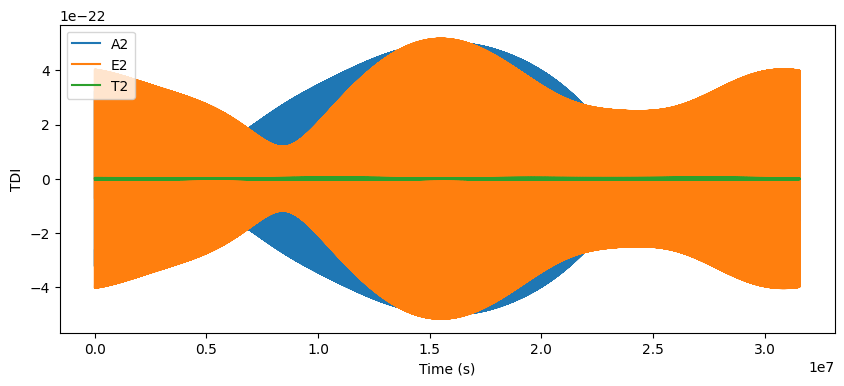

In [8]:
plt.figure(figsize=(10, 4))
for channel_name in ["A2", "E2", "T2"]:
    plt.plot(tdi.measurements["time"]["1"][100:-100], tdi.measurements[channel_name][100:-100] / F_LASER, label=channel_name)
plt.xlabel("Time (s)")
plt.ylabel("TDI")
plt.legend(loc="upper left")
# plt.xlim(100000,102000)

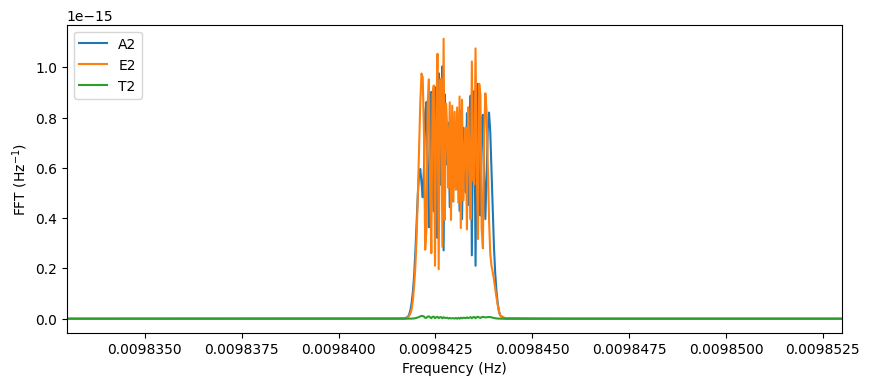

In [9]:
plt.figure(figsize=(10, 4))
for channel_name in ["A2", "E2", "T2"]:
    ff, xf = FFT_window(data_array=tdi.measurements[channel_name][100:-100] / F_LASER, fsample=fsample, window_type="tukey", window_args_dict=dict(alpha=0.1))
    plt.plot(ff, np.abs(xf), label=channel_name)
plt.xlim(0.00984299 - 1e-5, 0.00984299 + 1e-5)
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"${\rm FFT \ (Hz^{-1})}$")
plt.legend(loc="upper left")

## 2. Simulate MBHB signal using the PhenomT waveform of PyCBC
We showcase that external codes such as ``PyCBC`` can be used as the input of our simulator.   
Note that we only use ``PyCBC`` as a representative example for the various GW waveform generators, and it is not a necessary dependency of ``Triangle``.   

### 2.1 data, noise, orbit model settings 

In [10]:
fsample = 1.0
data_time = 10 * DAY
size = int(data_time * fsample)
interp_order = 15

orbit = Orbit(OrbitDir="../OrbitData/MicroSateOrbitEclipticTCB")
offset = OffsetFunctions(laser_flag=False, clock_flag=False)
noise = InstrumentalPSDs(L=L_nominal)

### 2.2 Initialize MBHB waveform and single-arm response 

In [11]:
# set parameters
Mc = 400000.0 # [Solar mass]
q = 0.3640815267051051 # [1]
spin1z = 0.7899406190510447 # [1]
spin2z = 0.015424596359292053 # [1]
tc = 5.0 * DAY # [s]
phic = 3.2535342675592966 # [rad]
D = 106039.10941463517 # [MPC]
inc = 1.4495086550199021 # [rad]

# set waveform template
approx = "IMRPhenomT"

# set the sampling rate to generate unprojedted polarizations
dt = 1.0

# initialize MBHB waveform
mbhb = MBHB(approx_method=approx)
mbhb(Mc=Mc, q=q, spin1z=spin1z, spin2z=spin2z, tc=tc, phic=phic, D=D, inc=inc, dt=dt)

lam = 3.032776598141215
beta = -1.1817968279048852
psi = 0.2409146690555858
gw = [
    GW(GWwaveform=mbhb, orbit=orbit, ext_params=[lam, beta, psi]),
]

### 2.3 Simulate interferometry data 

#### generate interferometry data 

In [12]:
ifo = Interferometers(
    size=size,
    fsample=fsample,
    time_frame="ProperTime",
    acc_noise=False,
    ro_noise=False,
    laser_noise=False,
    clock_noise=False,
    ob_noise=False,
    bl_noise=False,
    op_noise=False,
    ranging_noise=False,
    modulation_noise=False,
    orbit_class=orbit,
    offset_class=offset,
    noise_class=noise,
    gw_class=gw,
    fplan=None,
    order=interp_order,
    pool=pool,
    clean_memory=True,
)

ifo.SimulateInterferometers()
m = ifo.OutputMeasurements(mode="decomposed")
ifo.clean()

m1 = TPStoTCB(m, orbit_class=orbit, order=interp_order, pool=pool)
m1.keys()

dict_keys(['time', 'fsample', 'ltt', 'sci_c', 'sci_sb', 'ref_c', 'ref_sb', 'tm_c', 'a', 'b'])

### 2.4 TDI combination 

In [13]:
tdi = TDI(measurements=m1, delays=m1["ltt"], fsample=m1["fsample"], order=interp_order)
tdi.CalculateXi(doppler=True, pool=pool)  # no need to use the doppler delay since there are no laser noise.
tdi.CalculateEta(doppler=True)
tdi.FastMichelson(doppler=True, channel="AET")

tdi.measurements.keys()

dict_keys(['time', 'fsample', 'ltt', 'sci_c', 'sci_sb', 'ref_c', 'ref_sb', 'tm_c', 'a', 'b', 'dpl', 'xi', 'eta', 'X0', 'X1', 'X2', 'Y0', 'Y1', 'Y2', 'Z0', 'Z1', 'Z2', 'A0', 'E0', 'T0', 'A1', 'E1', 'T1', 'A2', 'E2', 'T2'])

#### plot TDI responses (in the fractional frequency difference unit)

Text(0, 0.5, 'TDI')

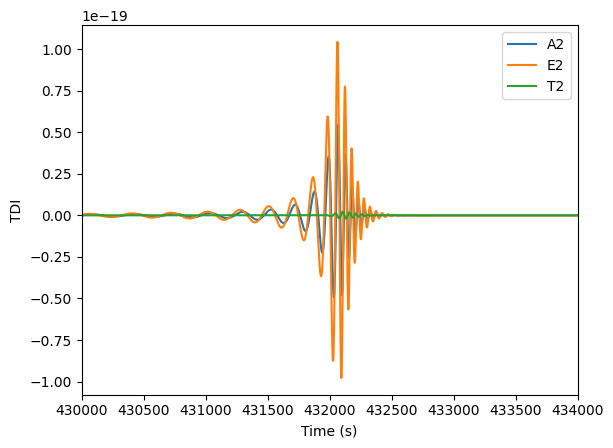

In [14]:
for channel_name in ["A2", "E2", "T2"]:
    plt.plot(tdi.measurements["time"]["1"][1000:-1000], tdi.measurements[channel_name][1000:-1000] / F_LASER, label=channel_name)
plt.xlim(tc - 2000, tc + 2000)
# plt.ylim(-1e-21, 1e-21)
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("TDI")

## 3. Simulate arbitrary signal from waveform data

### 3.1 data, noise, orbit model settings 

In [15]:
fsample = 0.1
data_time = 10 * DAY
size = int(data_time * fsample)
interp_order = 15

orbit = Orbit(OrbitDir="../OrbitData/MicroSateOrbitEclipticTCB")
offset = OffsetFunctions(laser_flag=False, clock_flag=False)
noise = InstrumentalPSDs(L=L_nominal)

### 3.2 Initialize general waveform and response 

In [16]:
waveform_data = np.load("../GWData/Demo_EMRI_waveform_data.npz")
tdata, hpdata, hcdata = waveform_data["t"], waveform_data["h1"], -waveform_data["h2"]  # since h2 is -hx

waveform_wrapper = GeneralWaveform(tdata, hpdata, hcdata)

# randomize 3 extrinsic parameters
lam = np.random.uniform(0, TWOPI)
beta = np.arcsin(np.random.uniform(-1, 1))
psi = np.random.uniform(0, PI)

# initialize GW object
gw = [
    GW(GWwaveform=waveform_wrapper, orbit=orbit, ext_params=[lam, beta, psi]),
]

### 3.3 simulate interferometric data and TDI combination 

In [17]:
ifo = Interferometers(
    size=size,
    fsample=fsample,
    time_frame="ProperTime",
    acc_noise=False,
    ro_noise=False,
    laser_noise=False,
    clock_noise=False,
    ob_noise=False,
    bl_noise=False,
    op_noise=False,
    ranging_noise=False,
    modulation_noise=False,
    orbit_class=orbit,
    offset_class=offset,
    noise_class=noise,
    gw_class=gw,
    fplan=None,
    order=interp_order,
    pool=pool,
    clean_memory=True,
)

ifo.SimulateInterferometers()
m = ifo.OutputMeasurements(mode="decomposed")
ifo.clean()

m1 = TPStoTCB(m, orbit_class=orbit, order=interp_order, pool=pool)

tdi = TDI(measurements=m1, delays=m1["ltt"], fsample=m1["fsample"], order=interp_order)
tdi.CalculateXi(doppler=True, pool=pool)
tdi.CalculateEta(doppler=True)
tdi.FastMichelson(doppler=True, channel="AET")

tdi.measurements.keys()

dict_keys(['time', 'fsample', 'ltt', 'sci_c', 'sci_sb', 'ref_c', 'ref_sb', 'tm_c', 'a', 'b', 'dpl', 'xi', 'eta', 'X0', 'X1', 'X2', 'Y0', 'Y1', 'Y2', 'Z0', 'Z1', 'Z2', 'A0', 'E0', 'T0', 'A1', 'E1', 'T1', 'A2', 'E2', 'T2'])

Text(0, 0.5, 'TDI')

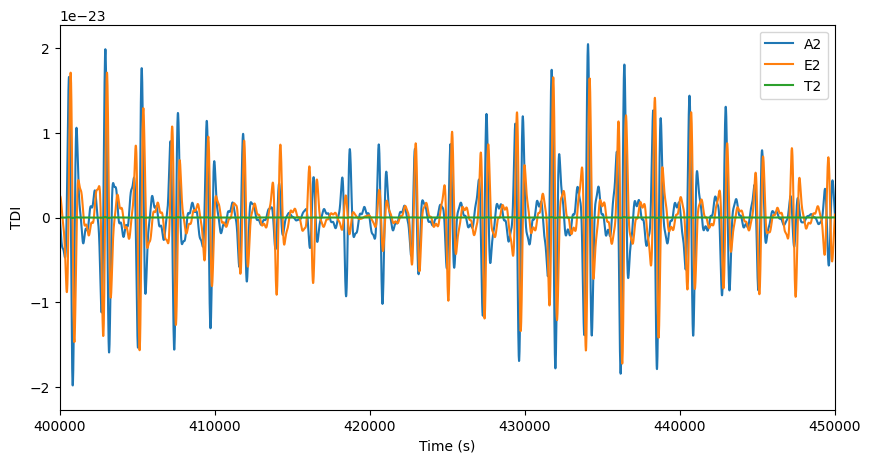

In [18]:
plt.figure(figsize=(10, 5))

for channel_name in ["A2", "E2", "T2"]:
    plt.plot(tdi.measurements["time"]["1"][1000:-1000], tdi.measurements[channel_name][1000:-1000] / F_LASER, label=channel_name)
plt.legend()
plt.xlim(4e5, 4e5 + 50000)
plt.xlabel("Time (s)")
plt.ylabel("TDI")

In ``Triangle.GW``, there is also a function ``Initial_GW_response`` which can be used to initialize the responses of MBHBs, GBs and other general waveforms in a more compact and unified manner (also see the next tutorial). 

## 4. Simulate SGWB 
SGWB is simulated as the superposition of stochastic GW signals from all directions.   
This approach might be slow, while it is better than simulating from the spectrum after TDI in the sense that it accounts for armlength variations and anisotropy. 

We use the relationship between GW power spectrum and GW fractional density: 
$$S_{\rm GW}(f) = \frac{3H_0^2}{4\pi^2 f^3}\Omega_{\rm GW}$$

The directions of incident GW signals are generated by the rule of HEALPIX. For an isotropic SGWB, in each direction 
$$S_{\rm GW}(f, \bm{\hat{n}}_k) = \frac{S_{\rm GW}(f)}{N_{\rm pix}}$$ 
$\bm{\hat{n}}_k$ being the unit vector pointing to the center of a certain pixel with index $i$,  ($i \in \{1, N_{\rm pix}\}$).   
We then randomly draw the signals $h_+(t, \bm{\hat{n}}_k), h_\times(t, \bm{\hat{n}}_k)$ from $S_{\rm GW}(f, \bm{\hat{n}}_k)$ in all directions.    
Then the incident GW signals are responded by the detector arms according to extrinsic parameters $\{\lambda_i, \beta_i, \psi=0\}$ (since $\psi$ is absorbed into $h_{+ / \times}$).    
The total single-arm responses read
$$y_{ij}(t) = \sum_{k=1}^{N_{\rm pix}} y_{ij}(t, \bm{\hat{n}}_k)$$

In this tutorial we take as an example the following SGWB model: 
$$\Omega_{\rm GW}(f) = \Omega_0 \left(\frac{f}{f_0}\right)^n$$

To verify the result, we use the theoretical PSD of $X_2$ channel: 
$$S_{X_2}(f) = \mathcal{R}_{X_2}(f) S_{\rm SGWB}(f)$$
In the low-frequency, equal-arm limit, the average response of $X_2$ reads 
$$\mathcal{R}_{X_2}(f) \approx \frac{96}{5} u^2 \sin^2(u) \sin^2(2u) \cos^2\left(\frac{u}{2}\right)$$
where $u \equiv 2\pi f L/c$, $L$ being the nominal armlength of detector.    
(Notice that here we define $\mathcal{R}$ as the transfer function from the spectrum of one polarization to the TDI output, which differs from our definition in the sensitivity calculation by a factor of 2).

### 4.1 Initialize unprojected polarizations 

In [19]:
fsample = 0.1 
data_time = 15 * DAY 
size = int(data_time * fsample)
interp_order = 11

offset = OffsetFunctions(laser_flag=False, clock_flag=False) 
noise = InstrumentalPSDs(L=L_nominal) 
orbit = Orbit(OrbitDir='../OrbitData/MicroSateOrbitEclipticTCB') 

As a simple illustration here we set $N_{\rm side} = 5 \Rightarrow N_{\rm pix} = 12\times N_{\rm side}^2 = 300$.    
For TDC II generation $N_{\rm side} = 10$ is used, hence $N_{\rm pix} = 1200$.

In [20]:
# define the SGWB fractional density 
def Omega_SGWB(f, Omega0, f0, n): 
    return Omega0 * (f / f0) ** n 

# define the PSD of polarizations 
def S_SGWB(f, Omega0=1e-11, f0=3.162e-3, n=-1.): 
    Omega = Omega_SGWB(f, Omega0, f0, n)
    return 3. * H0 ** 2 / 4. / np.pi ** 2 / f ** 3 * Omega * 1e6 / MPC ** 2 

# get the sky locations 
NSIDE = 5
NPIX = hlp.nside2npix(NSIDE)
print("number of directions:", NPIX)
colatitude, longitude = hlp.pix2ang(nside=NSIDE, ipix=np.arange(NPIX))
latitude = np.pi / 2. - colatitude

# generate stochastic signals in all the directions 
sgwb_generator = GeneralNoise(S_SGWB)
tdata = np.arange(size) / fsample
gw = [] 
for i in tqdm(range(NPIX)): 
    hp_k = sgwb_generator(fsample=fsample, size=size) / np.sqrt(NPIX)
    hc_k = sgwb_generator(fsample=fsample, size=size) / np.sqrt(NPIX)
    Waveform_k = GeneralWaveform(tdata=tdata, hpdata=hp_k, hcdata=hc_k)
    GW_k = GW(orbit=orbit, ext_params=[longitude[i], latitude[i], 0.], GWwaveform=Waveform_k) # here we set psi=0 since it is absorbed to h+ and hx
    gw.append(GW_k)

number of directions: 300


100%|██████████| 300/300 [00:10<00:00, 28.35it/s]


### 4.2 Calculate the total single-arm response 

In [21]:
ifo = Interferometers(
    size=size,
    fsample=fsample,
    time_frame="ProperTime",
    acc_noise=False,
    ro_noise=False,
    laser_noise=False,
    clock_noise=False,
    ob_noise=False,
    bl_noise=False,
    op_noise=False,
    ranging_noise=False,
    modulation_noise=False,
    orbit_class=orbit,
    offset_class=offset,
    noise_class=noise,
    gw_class=gw,
    fplan=None,
    order=interp_order,
    pool=pool,
    clean_memory=True,
)

ifo.SimulateInterferometers()
m = ifo.OutputMeasurements(mode="decomposed")
ifo.clean()

m1 = TPStoTCB(m, orbit_class=orbit, order=interp_order, pool=pool)

### 4.3 TDI combination 

In [22]:
tdi = TDI(measurements=m1, delays=m1["ltt"], fsample=m1["fsample"], order=interp_order)
tdi.CalculateXi(doppler=True, pool=pool)
tdi.CalculateEta(doppler=True)
tdi.FastMichelson(doppler=True, channel="XYZ")

tdi.measurements.keys()

dict_keys(['time', 'fsample', 'ltt', 'sci_c', 'sci_sb', 'ref_c', 'ref_sb', 'tm_c', 'a', 'b', 'dpl', 'xi', 'eta', 'X0', 'X1', 'X2', 'Y0', 'Y1', 'Y2', 'Z0', 'Z1', 'Z2'])

Text(0, 0.5, '${\\rm ASD \\ (Hz^{-1/2})}$')

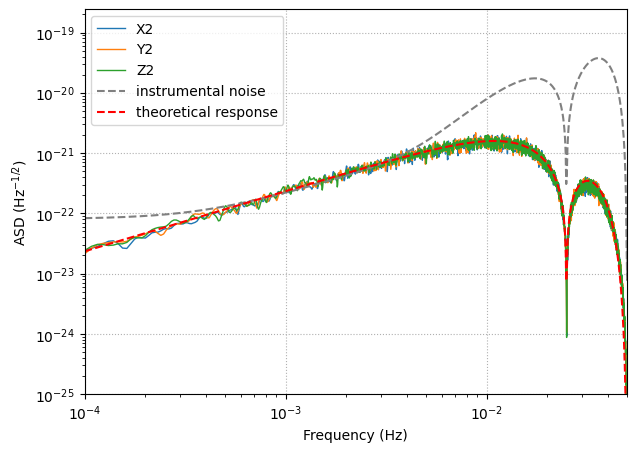

In [23]:
plt.figure(figsize=(7, 5))

drop_points = int(1000 * fsample)

for channel_name in ["X2", "Y2", "Z2"]:
    ff, xf = PSD_window(tdi.measurements[channel_name][drop_points:-drop_points]/F_LASER, fsample, nbin=10, window_type="kaiser", window_args_dict=dict(beta=28))
    plt.loglog(ff, np.sqrt(xf), linewidth=1, label=channel_name) 


plot_freqs = np.logspace(-4, -1, 1000)
PSDFunction = TDIPSDs()
plt.loglog(plot_freqs, np.sqrt(PSDFunction.PSD_X2(plot_freqs)), linestyle="--", color='grey', label="instrumental noise") # instrumental noise PSD in the equal-arm limit

plot_u = TWOPI * plot_freqs * L_nominal / C 
ResFunction = 96. / 5. * plot_u ** 2 * np.sin(plot_u) ** 2 * np.sin(2. * plot_u) ** 2 * np.cos(plot_u / 2.) ** 2 # average X2 response function in the equal-arm, long-wavelength limits
plt.loglog(plot_freqs, np.sqrt(ResFunction * S_SGWB(plot_freqs)), linestyle="--", color='red', label="theoretical response")

plt.grid(linestyle=":")
plt.legend(loc="upper left")
plt.ylim(1e-25, )
plt.xlim(1e-4, 0.05)
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"${\rm ASD \ (Hz^{-1/2})}$")